# Rosembrock Target Practice

## MCHMC

In [1]:
] activate "../"

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
target = RosenbrockTarget(0.1, 1.0, 10.0; d=4);

In [4]:
spl = MCHMC(10_000, 0.0001; sigma=ones(target.d), adaptive=true)

MicroCanonicalHMC.Sampler(Settings{Float64}(10000, 0.0001, 1, true, "LF", nothing, nothing, nothing), MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836, [1.0, 1.0, 1.0, 1.0], 0.9607843137254902, 1.5), MicroCanonicalHMC.Leapfrog)

In [5]:
samples_mchmc = Sample(spl, target, 500_000; dialog=true);

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):   0%|                                   |  ETA: 0:37:01

Burn in step: 2000
eps --->0.00013961517650570786


MCHMC (tuning):  20%|███████                            |  ETA: 0:00:04

L   --->1.0758496865308653e-5
 
Burn in step: 4000
eps --->5.021723803522455e-5
L   --->4.260124630673186e-6
 


MCHMC (tuning):  56%|███████████████████▌               |  ETA: 0:00:01

Burn in step: 6000
eps --->5.725202264016631e-5
L   --->4.341547872612337e-6
 
Burn in step: 8000
eps --->4.823715643131342e-5
L   --->3.296240483587078e-6
 


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:01

Burn in step: 10000
eps --->5.020691541339222e-5
L   --->3.136235866400529e-6
 


[ Info: eps: 5.020691541339222e-5
[ Info: L: 3.136235866400529e-6
[ Info: nu: 2.060423571963583e6
[ Info: sigma: [1.0, 1.0, 1.0, 1.0]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:04

In [6]:
d1_mchmc = [sample[1] for sample in samples_mchmc]
d2_mchmc = [sample[2] for sample in samples_mchmc];

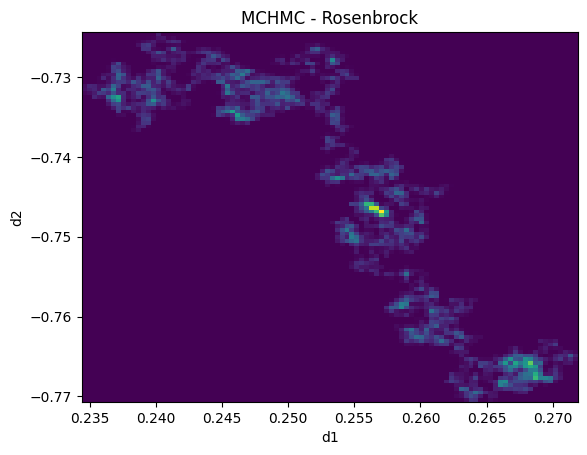

In [7]:
plt.hist2d(d1_mchmc, d2_mchmc, bins=100);
plt.xlabel("d1")
plt.ylabel("d2")
plt.title("MCHMC - Rosenbrock");

## NUTS

In [8]:
using AdvancedHMC
using LogDensityProblems

In [9]:
# Define the target distribution using the `LogDensityProblem` interface
struct LogTargetDensity
    dim::Int
end
LogDensityProblems.logdensity(p::LogTargetDensity, θ) = -target.nlogp(θ) #-sum(abs2, θ) / 2  # standard multivariate normal
LogDensityProblems.dimension(p::LogTargetDensity) = p.dim
LogDensityProblems.capabilities(::Type{LogTargetDensity}) = LogDensityProblems.LogDensityOrder{0}()

In [15]:
# Choose parameter dimensionality and initial parameter value
initial_θ = target.prior_draw()
ℓπ = LogTargetDensity(target.d)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 100_000, 10_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(target.d)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = AdvancedHMC.Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples_hmc, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true)

LoadError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{Base.Fix1{typeof(LogDensityProblems.logdensity), LogTargetDensity}, Float64}, Float64, 4})

[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat
[0m[90m   @[39m [90mBase[39m [90m[4mrounding.jl:207[24m[39m
[0m  (::Type{T})(::T) where T<:Number
[0m[90m   @[39m [90mCore[39m [90m[4mboot.jl:792[24m[39m
[0m  (::Type{T})([91m::AbstractChar[39m) where T<:Union{AbstractChar, Number}
[0m[90m   @[39m [90mBase[39m [90m[4mchar.jl:50[24m[39m
[0m  ...


In [13]:
d1_hmc = [sample[1] for sample in samples_hmc]
d2_hmc = [sample[2] for sample in samples_hmc];

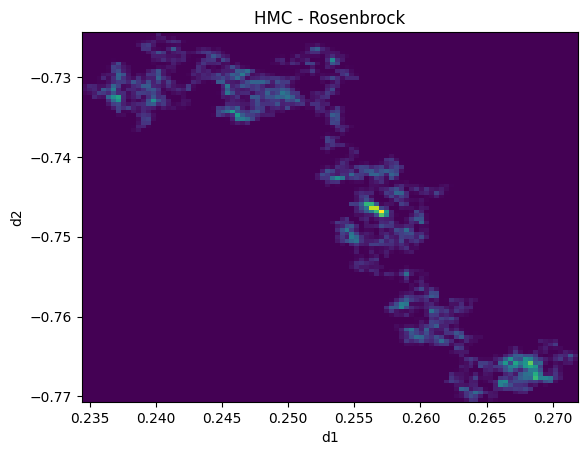

In [14]:
plt.hist2d(d1_hmc, d2_hmc, bins=100);
plt.xlabel("d1")
plt.ylabel("d2")
plt.title("HMC - Rosenbrock");